In [1]:
import sys
sys.path.append("C:\\Users\josep\Desktop\sus_packages")
import help_tools1
from help_tools1 import polar_coordinates
from wave_tools import ConstructWave, surface_core, peak_tracking
import wave_tools
#import cv2
import h5py
from matplotlib import cm
#import radar_tools
import numpy as np
#from wave_tools import ConstructWave, surface_core, peak_tracking
#from wave_tools import fft_interpolate, fft_interface, Spectrum
#from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools1 import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools1 import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math

# 3.3.1) Simulated Waves

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5'

# file with psi = 0 
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')


# file with psi = 30 and smax = 30 
#f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5', 'r')

In [3]:
psi = 0

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [5]:
eta = np.transpose(eta, (1, 2, 0))
# flips it into correct form (N, N, M)

In [6]:
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))

Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

## 1) Find Dispersion Relation

### 1.1) Smooth Tapering

In [7]:
def tapering_function(n, a, L):
    if 0 <= n <= a * L / 2:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 1)))
    elif a * L / 2 <= n <= L * (1 - a / 2):
        return 1
    elif L * (1 - a / 2) <= n <= L:
        return 0.5 * (1 + np.cos(np.pi * (2 * n / (a * L) - 2 / a + 1)))
    else:
        return 0.0

def apply_tapering_3d(data, a):
    shape = data.shape
    tapering_3d = np.ones(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                tapering_3d[i, j, k] = tapering_function(i, a, shape[0]) * tapering_function(j, a, shape[1]) * tapering_function(k, a, shape[2])

    tapered_data = data * tapering_3d

    return tapered_data

In [8]:
a_value = 0.1

In [9]:
tapered_eta = apply_tapering_3d(eta, a_value)

In [10]:
tapered_padded_eta = np.pad(tapered_eta, ((30,31), (30,31), (0, 0)), 'constant',  constant_values=0)

In [11]:
tapered_padded_eta.shape

(128, 128, 1200)

In [12]:
# Taper Applied
Nx, Ny, Nt = tapered_padded_eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [13]:
Norm = dKx * dKy * dW

In [14]:
# Get power spectra
Spectrum_raw = fftshift(fftn(tapered_padded_eta) / np.prod(tapered_padded_eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

### 1.2) HP Filter

In [15]:
I = power_Spectrum
I.shape

(128, 128, 1200)

In [16]:
w_cut = 0.03 * 2*np.pi

In [17]:
# Boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [18]:
I_1 = np.where(mask[ None, None,:], I, 0)

### 1.3) Energy Threshold Filter

In [19]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [20]:
I_2 = np.where(condition[:, :, None], I_1, 0)

### 1.4) Peak Identifcation

In [21]:
def identification(kx, ky, ratio=10., prominence=1e5, distance=5):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        values = []

        if len(peaks) == 1:
            values.append(w[peaks[0]])
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    #thing.append(w[peaks[ind]])
                    wj[kx,ky] = w[peaks[ind][0]]
    
    return wj 

In [22]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=10., prominence=1e5, distance=15))

In [23]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [24]:
w0 = w0_2D[w0_2D != 0]

In [25]:
nonzero_indices = np.nonzero(w0_2D)

In [26]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [27]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.45 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.5, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        surf = axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th, surf

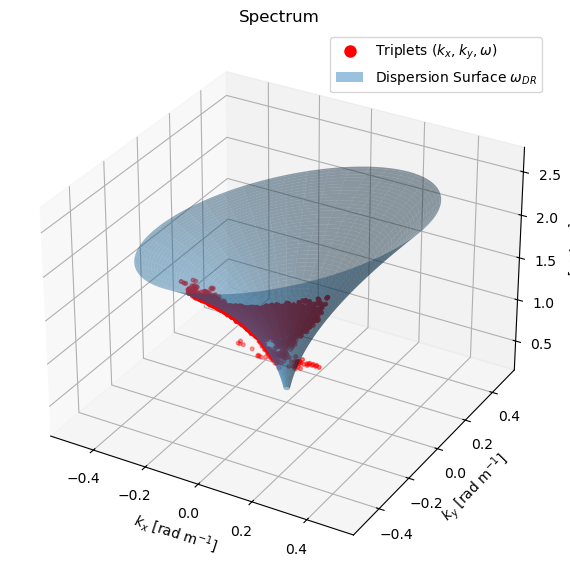

In [28]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0,  s = 7, color='red')
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th, surf = plot_disp_shell(ax, h=1000, z=z, U=U, psi = math.radians(psi) )

# Create legend manually with a dot for 'Triplets'
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Triplets $(k_{x}, k_{y}, \omega)$'),
    mpatches.Patch( label='Dispersion Surface $\omega_{DR}$',  alpha=0.45)
]

# Create legendA
ax.legend(handles=legend_elements)
 
# show plot
plt.show()

In [29]:
len(kx_trip)

2079

# 2) PCS Method 1

In [610]:
# kx_2D, ky_2D= np.meshgrid(kx_trip, ky_trip, indexing='ij')
kx_2D, ky_2D= np.meshgrid(Kx, Ky, indexing='ij')

In [611]:
K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
theta_2D = np.arctan2(ky_2D, kx_2D)

In [612]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [613]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [621]:
cut_k_array = np.arange(0.001, 0.35, 0.001)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]

    ind = np.where(np.round(K_2D, 2) == k_slice)
    
    # Slice at wavenumber cut_k - once k is within 0.01 it is counted as a slice
    w0_is_k = w0_2D[ind[0], ind[1]]
    theta_is_k = theta_2D[ind[0], ind[1]]
    
    # w and theta values along k_slice
    inds_where_w0_nonzero = np.where(w0_is_k != 0)
    
    if len(inds_where_w0_nonzero[0]) > 1:
        # How many nonzero w0 theres needs to be to be counted (increased numbers, increases accuracy)
        nonzero_theta_at_k = theta_is_k[inds_where_w0_nonzero]
        nonzero_w0_at_k = w0_is_k[inds_where_w0_nonzero]
        
        x_theta = nonzero_theta_at_k
        y_theta = (nonzero_w0_at_k - np.sqrt(9.81 * k_slice)) / k_slice
        
        # Preform Grubbs test to remove outliers
        x_theta, y_theta = grubbs_test(x_theta, y_theta)
        
        # Fitting Cos onto points
        pars0 = (max(y_theta), 1)  # initial guess
        popt, pcov = curve_fit(sinusoidinal, x_theta, y_theta, absolute_sigma=True, p0=pars0)
        
        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
        # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    else:
        # If no values in inds_where_w0_nonzero, append None or a placeholder value as needed
        U_array.append(None)
        Φ_array.append(None)


In [622]:
none_indices = [index for index, value in enumerate(U_array) if value is None]

U_array = [value for value in U_array if value is not None]
Φ_array = [value1 for value1 in Φ_array if value1 is not None]
cut_k_array = [value for index, value in enumerate(cut_k_array) if index not in none_indices]

In [675]:
k_new = cut_k_array
Ux_new = U_array * np.cos(Φ_array) 
Uy_new = U_array * np.sin(Φ_array) 

In [676]:
# Dont run again 

data1 = np.column_stack((k_new, Ux_new, Uy_new))
file_path = r"C:\Users\josep\Desktop\PHYC40900_Project TP\PCS_0.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='k\tUx\tUy')


file_path = r"C:\Users\josep\Desktop\PHYC40900_Project TP\PCS_0.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
k_data = loaded_data[:, 0]
Ux_data = loaded_data[:, 1]
Uy_data = loaded_data[:, 2]

(-0.2, 1.1)

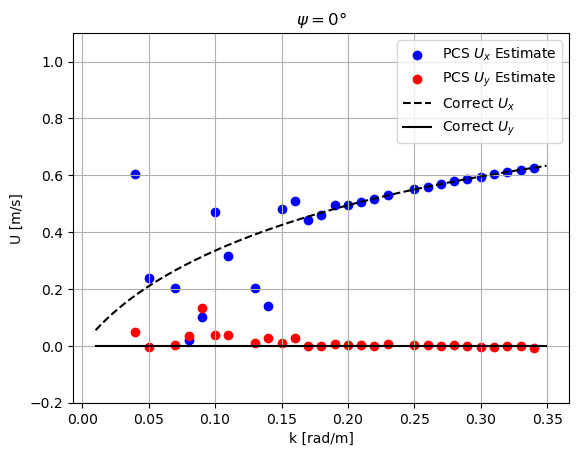

In [677]:
plt.scatter(k_data, Ux_data, color = 'blue', label = 'PCS $U_{x}$ Estimate')
plt.scatter(k_data,Uy_data, color = 'red', label = 'PCS $U_{y}$ Estimate')
plt.plot(k, Uk[:,0]*np.cos(psi), color = 'black', linestyle = '--',  label='Correct $U_x$')
plt.plot(k, Uk[:,0]*np.sin(psi), color = 'black', linestyle = '-',  label='Correct $U_y$')

plt.xlabel("k [rad/m]")
plt.ylabel("U [m/s]")
plt.title(f"$\psi={psi} \degree$")
plt.grid(True)
plt.legend()
plt.ylim(-0.2, 1.1)

## 3) PCS Method 2

## 3.1) Surface Interpolation

In [345]:
cond_high_k = (-ky_trip < -0.05)
# removing low wavenumbers

In [346]:
kx_trip = kx_trip[cond_high_k]
ky_trip = ky_trip[cond_high_k]
w0 = w0[cond_high_k]

In [347]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from numpy import ones, vstack
from numpy.linalg import lstsq
from sklearn.metrics import mean_squared_error

In [348]:
x = np.insert(-kx_trip, 0, 0)
y = np.insert(-ky_trip, 0, 0)
z = np.insert(w0, 0, 0)


In [349]:
#%matplotlib widget

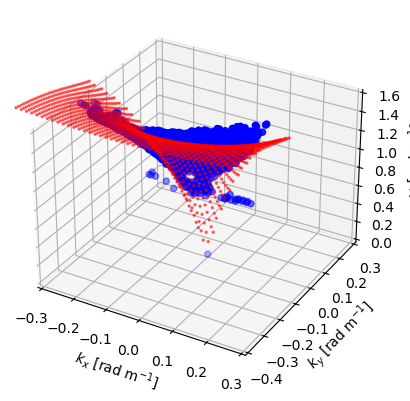

In [350]:
# Find the maximum and minimum x values
# Calculate polar coordinates (theta) using arctangent function
theta_values = np.arctan2(y, x)

i_min = np.where(np.isclose(theta_values, np.min(theta_values)))
i_max = np.where(np.isclose(theta_values,np.max( theta_values[(theta_values != 0)])))
x_max = x[i_max][0]
x_min = x[i_min][0]

# Find the corresponding y values (i.e. y values of those points where x is maximum)
y_max = y[i_max][0]
y_min = y[i_min][0]

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182
def line_coeffs(points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords, ones(len(x_coords))]).T
    # y = a*x + b
    a, b = lstsq(A, y_coords, rcond=None)[0]
    return (a, b)

# Find coefficients of the two lines "limiting" all points left and right across the x-axis in the XY-plane
k1_max, k2_max = line_coeffs([(x_max, y_max), (0, 0)])
k1_min, k2_min = line_coeffs([(x_min, y_min), (0, 0)])

# Function finding 2D-line coefficients, based on this answer https://stackoverflow.com/a/21566184/3715182

def func(xy, a, b):
    x, y = xy
    r = np.sqrt(x ** 2 + y ** 2)
    return a*(1-np.exp(-b*r))


# Create a grid of points over the surface
x_fill = np.linspace(-0.3, 0.3, 40)
y_fill = np.linspace(-0.5, 0, 40)
X_fill, Y_fill = np.meshgrid(x_fill, y_fill)

# Perform curve fitting 
popt, pcov = curve_fit(func, (x, y), z, maxfev = 2000)

# Evaluate the function at each point on the surface
Z_fill = func((X_fill, Y_fill), *popt)

# Plot the data points and the filled surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue', label='Data Points')

ax.scatter(np.where(X_fill >= (Y_fill - k2_min)/k1_min, np.where(X_fill <= (Y_fill - k2_max)/k1_max, X_fill, np.nan), np.nan), Y_fill, Z_fill, color='red', alpha=0.5, s= 2)

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.4, 0.3])
ax.set_zlim([0, 1.6])

ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
ax.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
ax.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')

plt.show()

In [351]:
predicted_values = func((x, y), *popt)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(z, predicted_values))
rmse

0.07555092526172087

In [352]:
# Find the interpolated points
interpolated_points_x = np.where(X_fill >= (Y_fill - k2_min) / k1_min,
                                  np.where(X_fill <= (Y_fill - k2_max) / k1_max, X_fill, np.nan), np.nan).flatten()
interpolated_points_y = Y_fill.flatten()
interpolated_points_z = Z_fill.flatten()

In [353]:
not_nan_indices = np.where(~np.isnan(interpolated_points_x))

In [354]:
kx_triplets = interpolated_points_x[not_nan_indices]
ky_triplets = interpolated_points_y[not_nan_indices]
w_triplets = interpolated_points_z[not_nan_indices]

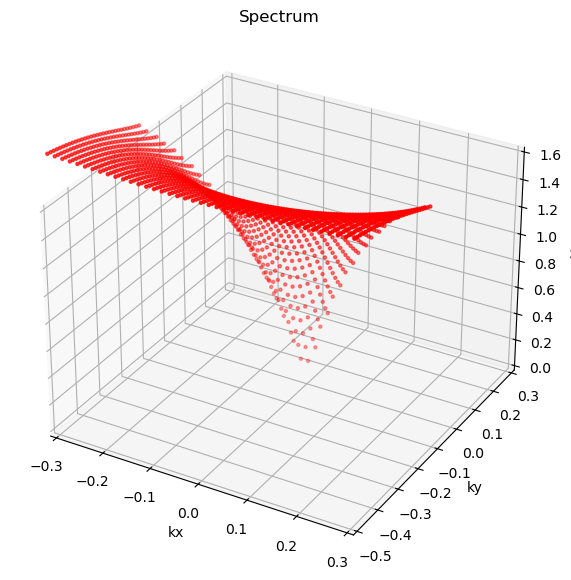

In [355]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_triplets, ky_triplets, w_triplets, color = "red", s = 5)
plt.title("Spectrum")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.5, 0.3])
ax.set_zlim([0, 1.6])
 
# show plot
plt.show()

## 3.2) Perform Algorithm

In [356]:
from scipy.stats import t

In [357]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b)

In [358]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [359]:
#cut_k_array = np.arange(0.001, 0.35, 0.01)
cut_k_array = np.arange(0.05, 0.35, 0.01)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]
    
    k_abs = np.sqrt(kx_triplets**2 + ky_triplets**2)
    theta = np.arctan2(ky_triplets, kx_triplets)
    
    reso = 0.005
    ind = np.where(((k_slice - reso) < k_abs ) & ( k_abs < (k_slice + reso)))
    
    if len(w_triplets[ind]) > 10:
    
        x1 = theta[ind]
        y = ( w_triplets[ind] - np.sqrt(9.81*k_slice) )  / k_slice
    
        # Perform Grubbs test
        x1, y = grubbs_test(x1, y)
    
    
        # initial guess
        pars0 = ( max(y), 1)
        popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
            # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    
    else:
        U_array.append(None)
        Φ_array.append(None)

In [360]:
%matplotlib inline

In [361]:
none_indices = [index for index, value in enumerate(U_array) if value is None]


In [362]:
U_array = [value for value in U_array if value is not None]
Φ_array = [value1 for value1 in Φ_array if value1 is not None]
cut_k_array = [value for index, value in enumerate(cut_k_array) if index not in none_indices]

In [569]:
# Dont Run

data = np.column_stack((cut_k_array, U_array, Φ_array))
file_path = r"C:\Users\josep\Desktop\PHYC40900_Project TP\PCS_0_inter.txt"
#np.savetxt(file_path, data, delimiter='\t', header='k\tU\tpsi')

In [5]:
file_path = r"C:\Users\josep\Desktop\PHYC40900_Project TP\PCS_0_inter.txt"

# data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# Extract columns
interp_k = loaded_data[:, 0]
interp_U = loaded_data[:, 1]
interp_psi = loaded_data[:, 2]

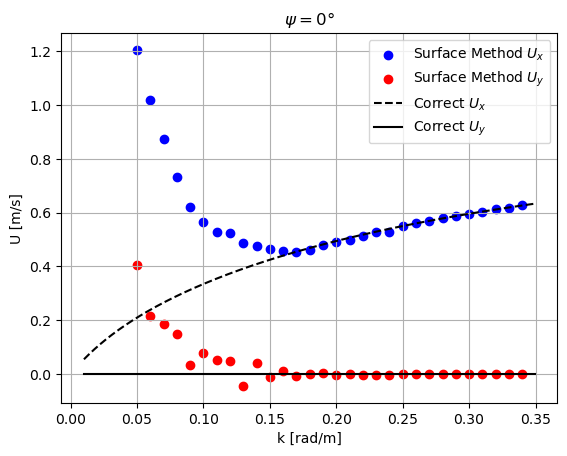

In [6]:
plt.scatter(interp_k, interp_U*np.cos(interp_psi), color = 'blue', label = 'Surface Method $U_{x}$')
plt.scatter(interp_k, interp_U*np.sin(interp_psi), color = 'red', label = 'Surface Method $U_{y}$')
plt.plot(k, Uk[:,0], color = 'black', linestyle='--',label = 'Correct $U_{x}$')
plt.plot(k, 0*k, color = 'black', linestyle='-',label = 'Correct $U_{y}$')

plt.xlabel("k [rad/m]")
plt.ylabel("U [m/s]")
plt.title(f"$\psi={psi}\degree$")
plt.legend(loc='upper right')

#plt.ylim(-0.3, 1.13)
plt.grid(True)